<a href="https://colab.research.google.com/github/xeonqq/FourierFeatureSiren/blob/main/ffn_vs_siren_and_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier Feature Network (FFN) VS Siren, can we combine them?

This is a colab to compare the performace of [Fourier Feature Network (FFN)](https://bmild.github.io/fourfeat/) and Siren MLP, proposed in work [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren). In terms of accuracy in image fitting.

In the end, a combined version of FFN and Siren (FFNSiren) is presented, which shows the best performace.


* The Siren implementation is a copy-paste from the original implementation from the author

* FFN implementation is a pytorch port from the original jax implemenation from the author. (But replacing the last sigmoid layer with tanh) 

In [289]:
from collections import OrderedDict

import cv2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

device = "cuda" if torch.cuda.is_available() else "cpu"


def get_mgrid(sidelen, dim=2):
    """Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int
    """
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid   = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid   = mgrid.reshape(-1, dim)
    return mgrid

In [290]:
print(device)

cuda


In [291]:
torch.manual_seed(0)

In [292]:
losses        = {}
psnrs         = {}
outputs       = {}
total_steps   = 300  # Since the whole image is our dataset, this just means 500 gradient descent steps.
summary_steps = 10
image_file    = "data/04_image_lr.png"
output_dir    = "run/ffsr"
save_images   = True
font_size     = 18
line_width    = 2.0
fig_size      = (5, 4.5)
matplotlib.rc("font", **{
	# "family" : "normal",
	"size"   : font_size
})
plt.rcParams["figure.figsize"]    = [5, 4.5]
plt.rcParams["figure.autolayout"] = True


def get_image_tensor(sidelength):
	# img = Image.fromarray(skimage.data.camera())
	img       = Image.open(image_file).convert("L")
	transform = Compose([
		Resize((sidelength, sidelength)),
		ToTensor(),
		Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
	])
	return transform(img)


img = get_image_tensor(256).numpy()
np.min(img[0].reshape((-1)))
print(img.shape)

(1, 256, 256)


Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [293]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0     = omega_0
        self.is_first    = is_first
        self.in_features = in_features
        self.linear      = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
	
    def __init__(
	    self, 
	    in_features,
	    hidden_features,
	    hidden_layers,
	    out_features,
	    outermost_linear = False,
	    first_omega_0    = 30,
	    hidden_omega_0   = 1
    ):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, is_first=True, omega_0=first_omega_0))
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, is_first=False, omega_0=hidden_omega_0))
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        """Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!
        """
        activations      = OrderedDict()
        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations["input"] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
             
                activations["_".join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations["_".join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [294]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

<a id='section_1'></a>
## Fitting an image

First, let's simply fit that image!

We seek to parameterize a greyscale image $f(x)$ with pixel coordinates $x$ with a SIREN $\Phi(x)$.

That is we seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image. 
 
We write a little datast that does nothing except calculating per-pixel coordinates:

In [295]:
class ImageFitting(Dataset):
	
    def __init__(self, sidelength):
        super().__init__()
        img         = get_image_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).reshape(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: 
	        raise IndexError
        return self.coords, self.pixels

In [296]:
img    = get_image_tensor(256)
pixels = img.permute(1, 2, 0).reshape(-1, 1)
print(pixels.shape)

torch.Size([65536, 1])


In [297]:
cameraman  = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [298]:
siren_w1 = Siren(in_features=2, out_features=1, hidden_features=256, hidden_layers=4, outermost_linear=True, first_omega_0=30, hidden_omega_0=1)
siren_w1.to(device)

siren_w30 = Siren(in_features=2, out_features=1, hidden_features=256, hidden_layers=4, outermost_linear=True, first_omega_0=30, hidden_omega_0=30)
siren_w30.to(device)

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [299]:
# print(sum(p.numel() for p in siren.parameters()) / 1e6, "M parameters")

In [300]:
print(f"total pixels {256 * 256 / 1e6}")

total pixels 0.065536


## Training Loop

In [301]:
def train(model, model_name, dataloader, total_steps, steps_til_summary, plot_gradient=False):
  # plot_gradient consumes way more memory
  optim = torch.optim.Adam(lr=1e-4, params=model.parameters())

  model_input, ground_truth = next(iter(dataloader))
  model_input, ground_truth = model_input.to(device), ground_truth.to(device)

  losses       = []
  images       = []
  groundtruths = []
  for step in range(total_steps):
      model_output, coords = model(model_input)    
      loss = ((model_output - ground_truth) ** 2).mean()
      losses.append(loss.item())
      if not step % steps_til_summary or (step==total_steps - 1):
          print("Step %d, Total loss %0.6f" % (step, loss))
          image = model_output.cpu().view(256, 256).detach().numpy()
          images.append(image)
          groundtruths.append(ground_truth.cpu().view(256, 256).detach().numpy())
          if plot_gradient:
            img_grad      = gradient(model_output, coords)
            img_laplacian = laplace(model_output, coords)
            fig, axes     = plt.subplots(1, 3, figsize=(18, 6))
            axes[0].imshow(image)
            axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256, 256).detach().numpy())
            axes[2].imshow(img_laplacian.cpu().view(256, 256).detach().numpy())
          # else:
            # plt.imshow(image)
          # plt.show()

      optim.zero_grad()
      loss.backward()
      optim.step()
  torch.cuda.empty_cache()

  return losses, images, groundtruths

## Fourier Feature

In [302]:
def input_mapping(x, B):
  if B is None:
    return x
  else:
    x_proj    = (2. * np.pi * x) @ B.T
    embedding = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], axis=-1)
    return embedding

In [303]:
class FFN(nn.Module):
	
    def __init__(
	    self, 
	    in_features,
	    out_features,
	    hidden_dim,
	    n_hidden_layers,
	    trainable_B     = False,
	    embedding_dim   = 256,
	    gaussian_scale  = 10
    ):
        super().__init__()
        if trainable_B:
          B = torch.randn((embedding_dim,in_features),requires_grad=True)*gaussian_scale
          self.register_parameter(name="B", param=torch.nn.Parameter(B))
        else:
          self.register_buffer("B", torch.randn((embedding_dim,in_features))*gaussian_scale)
       
        layers = []
        layers.append(nn.Linear(embedding_dim*2, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, out_features))
        layers.append(nn.Tanh())

        self.mlp = nn.Sequential(*layers)

    def forward(self, coords): 
        coords    = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        embedding = input_mapping(coords, self.B)
        x         = self.mlp(embedding)
        return x, coords


torch.cuda.empty_cache()

ffn = FFN(2, 1, 256, 2, False)
ffn.to(device)
print(sum(p.numel() for p in ffn.parameters()) / 1e6, "M parameters")
print( [p.shape for p in ffn.parameters()])

0.263169 M parameters
[torch.Size([256, 512]), torch.Size([256]), torch.Size([256, 256]), torch.Size([256]), torch.Size([256, 256]), torch.Size([256]), torch.Size([1, 256]), torch.Size([1])]


In [304]:
class FFSiren(nn.Module):
	
    def __init__(
	    self, 
	    in_features, 
	    out_features, 
	    hidden_dim, 
	    n_hidden_layers, 
	    embedding_dim  = 256, 
	    gaussian_scale = 10,
	    first_omega_0  = 30,
	    hidden_omega_0 = 1
    ):
        super().__init__()
        self.register_buffer("B", torch.randn((embedding_dim, in_features)) * gaussian_scale)
        self.siren = Siren(
	        in_features      = embedding_dim * 2,
	        out_features     = out_features,
	        hidden_features  = hidden_dim,
	        hidden_layers    = n_hidden_layers,
	        first_omega_0    = first_omega_0,
	        hidden_omega_0   = hidden_omega_0,
	        outermost_linear = True,
        )
    
    def forward(self, coords): 
        embedding = input_mapping(coords, self.B)
        return self.siren(embedding)


ffsiren = FFSiren(2, 1, 256, 2, first_omega_0=30, hidden_omega_0=30)
ffsiren.to(device)
print(sum(p.numel() for p in ffsiren.parameters()) / 1e6, "M parameters")

0.263169 M parameters


In [305]:
class FINERLayer(nn.Module):
	"""FINER Layer.
    
    For the value of ``first_bias_scale``, see Fig. 5 in the paper.
    
    Args:
        in_channels: The number of input channels.
        out_channels: The number of output channels.
        bias: Whether to use bias. Defaults: ``True``.
        is_first: Whether this is the first layer. Defaults: ``False``.
        omega_0: The frequency of the sine activation function. Defaults: ``30.0``.
        first_bias_scale: The scale of the first bias. Defaults: ``20.0``.
        scale_req_grad: Whether the scale requires gradient. Defaults: ``False``.
    
    References:
        https://github.com/liuzhen0212/FINER/blob/main/models.py
    """
	
	def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30, first_bias_scale=None, scale_req_grad=False):
		super().__init__()
		self.omega_0     = omega_0
		self.is_first    = is_first
		self.in_features = in_features
		self.linear      = nn.Linear(in_features, out_features, bias=bias)
		
		self.init_weights()
		self.scale_req_grad   = scale_req_grad
		self.first_bias_scale = first_bias_scale
		if self.first_bias_scale is not None:
			self.init_first_bias()
	
	def init_weights(self):
		with torch.no_grad():
			if self.is_first:
				self.linear.weight.uniform_(-1 / self.in_features,
				                             1 / self.in_features)
			else:
				self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
				                             np.sqrt(6 / self.in_features) / self.omega_0)
	
	def init_first_bias(self):
		with torch.no_grad():
			if self.is_first:
				self.linear.bias.uniform_(-self.first_bias_scale, self.first_bias_scale)
	
	def generate_scale(self, x: torch.Tensor) -> torch.Tensor:
		if self.scale_req_grad:
			scale = torch.abs(x) + 1
		else:
			with torch.no_grad():
				scale = torch.abs(x) + 1
		return scale
	
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		x     = self.linear(x)
		scale = self.generate_scale(x)
		out   = torch.sin(self.omega_0 * scale * x)
		return out


class FINER(nn.Module):
	"""FINER network.
    
    References:
        https://github.com/liuzhen0212/FINER/blob/main/models.py
    """
	
	def __init__(
		self,
		in_features,
		out_features,
		hidden_features,
		hidden_layers,
		outermost_linear = False,
		first_omega_0    = 30,
		hidden_omega_0   = 30,
		first_bias_scale = None,
	):
		super().__init__()
		net = [FINERLayer(in_features, hidden_features, is_first=True, omega_0=first_omega_0, first_bias_scale=first_bias_scale)]
		for i in range(hidden_layers):
			net.append(FINERLayer(hidden_features, hidden_features, is_first=False, omega_0=hidden_omega_0))
		
		if outermost_linear:
		    final_linear = nn.Linear(hidden_features, out_features)
		    with torch.no_grad():
			    final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, np.sqrt(6 / hidden_features) / hidden_omega_0) 
			    net.append(final_linear) 
		else:
			net.append(FINERLayer(in_features, hidden_features, is_first=False, omega_0=hidden_omega_0))
		self.net = nn.Sequential(*net)
		
	def forward(self, coords):
		coords = coords.clone().detach().requires_grad_(True)
		output = self.net(coords)
		return output, coords


torch.cuda.empty_cache()

finer = FINER(in_features=2, out_features=1, hidden_features=256, hidden_layers=4, outermost_linear=True, first_bias_scale=None)
finer.to(device)
print(sum(p.numel() for p in finer.parameters()) / 1e6, "M parameters")

finer_b20 = FINER(in_features=2, out_features=1, hidden_features=256, hidden_layers=4, outermost_linear=True, first_bias_scale=20)
finer_b20.to(device)
print(sum(p.numel() for p in finer_b20.parameters()) / 1e6, "M parameters")

0.264193 M parameters
0.264193 M parameters


In [306]:
class FFFINER(nn.Module):
	
	def __init__(
		self,
		in_features,
		out_features,
		hidden_dim, 
		n_hidden_layers,
		first_omega_0    = 30,
		hidden_omega_0   = 30,
		first_bias_scale = 20,
		embedding_dim    = 256,
		gaussian_scale   = 10,
	):
		super().__init__()
		self.register_buffer("B", torch.randn((embedding_dim, in_features)) * gaussian_scale)
		self.siren = FINER(
			in_features      = embedding_dim * 2,
			out_features     = out_features,
			hidden_features  = hidden_dim,
			hidden_layers    = n_hidden_layers,
			first_omega_0    = first_omega_0,
			hidden_omega_0   = hidden_omega_0,
			first_bias_scale = first_bias_scale,
			outermost_linear = True
		)
	
	def forward(self, coords):
		embedding = input_mapping(coords, self.B)
		return self.siren(embedding)


fffiner = FFFINER(2, 1, 256, 2, first_omega_0=30, hidden_omega_0=30, first_bias_scale=None, gaussian_scale=10)
fffiner.to(device)
print(sum(p.numel() for p in ffsiren.parameters()) / 1e6, "M parameters")

0.263169 M parameters


## Begin Training

In [307]:
loss, output, groundtruths = train(ffn, "FFN", dataloader, total_steps, summary_steps)
outputs["Groundtruth"] = groundtruths
outputs["FFN"]         = output
losses["FFN"]          = loss

Step 0, Total loss 0.514328
Step 10, Total loss 0.495486
Step 20, Total loss 0.489373
Step 30, Total loss 0.479251
Step 40, Total loss 0.462835
Step 50, Total loss 0.433217
Step 60, Total loss 0.381511
Step 70, Total loss 0.302296
Step 80, Total loss 0.207104
Step 90, Total loss 0.123412
Step 100, Total loss 0.069700
Step 110, Total loss 0.043495
Step 120, Total loss 0.030675
Step 130, Total loss 0.022933
Step 140, Total loss 0.017819
Step 150, Total loss 0.014296
Step 160, Total loss 0.011708
Step 170, Total loss 0.009767
Step 180, Total loss 0.008298
Step 190, Total loss 0.007166
Step 200, Total loss 0.006269
Step 210, Total loss 0.005548
Step 220, Total loss 0.004968
Step 230, Total loss 0.004505
Step 240, Total loss 0.004124
Step 250, Total loss 0.003805
Step 260, Total loss 0.003534
Step 270, Total loss 0.003299
Step 280, Total loss 0.003092
Step 290, Total loss 0.002909
Step 299, Total loss 0.002761


In [308]:
# losses["SIREN"], outputs["SIREN"] = train(siren_w1, "SIREN", dataloader, total_steps, steps_til_summary)

In [309]:
losses["SIREN"], outputs["SIREN"], groundtruths = train(siren_w30, "SIREN w0=30", dataloader, total_steps, summary_steps)

Step 0, Total loss 0.549045
Step 10, Total loss 0.083302
Step 20, Total loss 0.021694
Step 30, Total loss 0.011009
Step 40, Total loss 0.007768
Step 50, Total loss 0.006518
Step 60, Total loss 0.005849
Step 70, Total loss 0.005440
Step 80, Total loss 0.005135
Step 90, Total loss 0.004889
Step 100, Total loss 0.004676
Step 110, Total loss 0.004486
Step 120, Total loss 0.004314
Step 130, Total loss 0.004158
Step 140, Total loss 0.004016
Step 150, Total loss 0.003888
Step 160, Total loss 0.003770
Step 170, Total loss 0.003663
Step 180, Total loss 0.003564
Step 190, Total loss 0.003473
Step 200, Total loss 0.003394
Step 210, Total loss 0.003347
Step 220, Total loss 0.003273
Step 230, Total loss 0.003183
Step 240, Total loss 0.003108
Step 250, Total loss 0.003046
Step 260, Total loss 0.002984
Step 270, Total loss 0.002925
Step 280, Total loss 0.002867
Step 290, Total loss 0.002811
Step 299, Total loss 0.002761


In [310]:
# losses["FINER"], outputs["FINER"], groundtruths = train(finer, "FINER", dataloader, total_steps, steps_til_summary)

In [311]:
# losses["FINER"], outputs["FINER"], groundtruths = train(finer_b20, "FINER b=20", dataloader, total_steps, steps_til_summary)

In [312]:
losses["FFSR"], outputs["FFSR"], groundtruths = train(ffsiren, "FFSR", dataloader, total_steps, summary_steps)

Step 0, Total loss 0.507789
Step 10, Total loss 0.398036
Step 20, Total loss 0.073091
Step 30, Total loss 0.022127
Step 40, Total loss 0.012028
Step 50, Total loss 0.006540
Step 60, Total loss 0.003806
Step 70, Total loss 0.002508
Step 80, Total loss 0.001841
Step 90, Total loss 0.001467
Step 100, Total loss 0.001232
Step 110, Total loss 0.001070
Step 120, Total loss 0.000949
Step 130, Total loss 0.000859
Step 140, Total loss 0.001048
Step 150, Total loss 0.000811
Step 160, Total loss 0.000738
Step 170, Total loss 0.000643
Step 180, Total loss 0.000572
Step 190, Total loss 0.000520
Step 200, Total loss 0.000479
Step 210, Total loss 0.000444
Step 220, Total loss 0.000413
Step 230, Total loss 0.000384
Step 240, Total loss 0.000358
Step 250, Total loss 0.000333
Step 260, Total loss 0.000312
Step 270, Total loss 0.000567
Step 280, Total loss 0.000502
Step 290, Total loss 0.000453
Step 299, Total loss 0.000265


In [313]:
# losses["FFSR"], outputs["FFSR"], groundtruths = train(fffiner, "FFSR", dataloader, total_steps, steps_til_summary)

In [314]:
from scipy.ndimage import gaussian_filter1d


def loss_to_psnr(loss, max=2):
  # return 10 * np.log10(max ** 2 / np.asarray(loss))
  return -10 * np.log10(2.0 * np.asarray(loss))

Final Loss:
FFN: 0.002760730916634202
SIREN: 0.0027609968092292547
FFSR: 0.0002652529801707715
FFN: 0.002760730916634202
SIREN: 0.0027609968092292547
FFSR: 0.0002652529801707715


<Figure size 500x450 with 0 Axes>

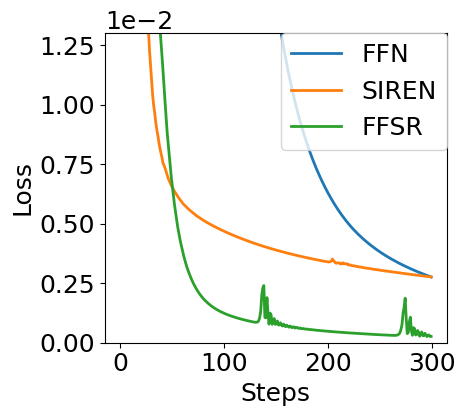

In [315]:
print("Final Loss:")

#plt.figure(figsize=fig_size)
plt.subplots(figsize=fig_size)
for n in losses:
	plt.plot(losses[n], label=n, linewidth=line_width)
	plt.legend(prop={"size": font_size})
	print(f"{n}: {losses[n][-1]}")
plt.xlabel("Steps")
plt.ylabel("Loss")
# plt.ylim(0.0, 1.0)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)
plt.savefig(f"{output_dir}/loss_{total_steps}.jpg", dpi=100, bbox_inches="tight")

plt.clf()
#plt.figure(figsize=fig_size)
plt.subplots(figsize=fig_size)
for n in losses:
  plt.plot(losses[n], label=n, linewidth=line_width)
  plt.legend(prop={"size": font_size})
  print(f"{n}: {losses[n][-1]}")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.ylim(0.0, 0.013)
#plt.ylim(0.0, 0.5)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)
plt.savefig(f"{output_dir}/loss_{total_steps}_small.jpg", dpi=100, bbox_inches="tight")

Final PSNR:
PSNR FFN: 22.57945925518518
PSNR SIREN: 22.57904099592782
PSNR FFSR: 32.753097323490664


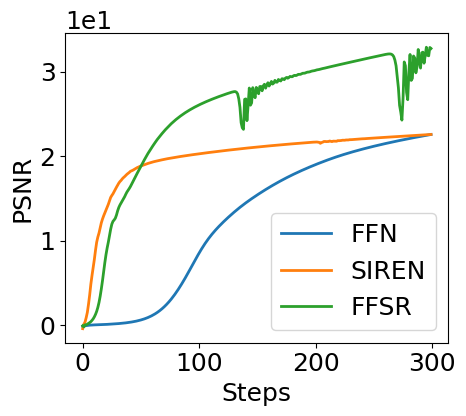

In [316]:
print("Final PSNR:")

#plt.figure(figsize=fig_size)
plt.subplots(figsize=fig_size)
for n in losses:
  plt.plot(despike(loss_to_psnr(losses[n])), label=n, linewidth=line_width)
  plt.legend(prop={"size": font_size})
  psnrs[n] = loss_to_psnr(losses[n][-1])
  print(f"PSNR {n}: {loss_to_psnr(losses[n][-1])}")
plt.xlabel("Steps")
plt.ylabel("PSNR")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
# plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)
plt.savefig(f"{output_dir}/psnr_{total_steps}.jpg", dpi=100, bbox_inches="tight")

In [317]:
!pip install imageio-ffmpeg
import os, imageio

In [318]:
# Save out video
if save_images:
    all_preds = np.concatenate([outputs[n] for n in outputs], axis=-1)
    data8     = (255 * (np.clip(all_preds, -1, 1) + 1) / 2).astype(np.uint8)
    f         = os.path.join(f"{output_dir}/training_convergence_{total_steps}.mp4")
    imageio.mimwrite(f, data8, fps=20)
    N = len(outputs)
    # Display video inline
    from IPython.display import HTML
    from base64 import b64encode

    mp4      = open(f, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [319]:
HTML(f'''
<video width=1000 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>
<table width="1000" cellspacing="0" cellpadding="0">
  <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
  <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
</table>
'''.format(*list(outputs.keys())))

,,,
Groundtruth,FFN,SIREN,FFSR


Text(0.5, 1.0, 'groundtruth')

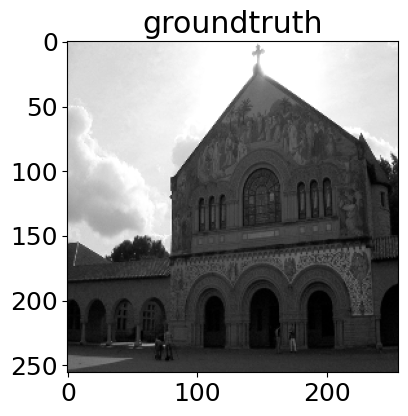

In [320]:
gt_img = np.around((get_image_tensor(256) / 2 + 0.5)[0].numpy() * 255).astype(np.uint8)
plt.imshow(gt_img, cmap="gray")
plt.title("groundtruth")

In [321]:
print(data_url)

data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQACDMJtZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1OSByMjk5MSAxNzcxYjU1IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxOSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTggbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTIwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS

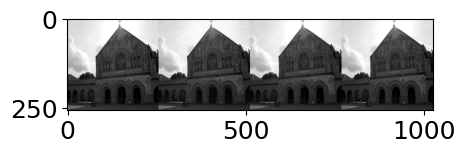

In [322]:
plt.imshow(data8[-1], cmap="gray")

In [323]:
def mse(image1, image2):
  image_array1 = np.array(image1)
  image_array2 = np.array(image2)
  # Calculate the squared difference
  squared_difference = (image_array1 - image_array2) ** 2
  # Calculate the mean squared difference
  return np.mean(squared_difference)

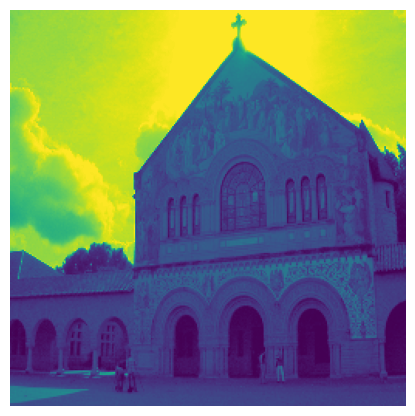

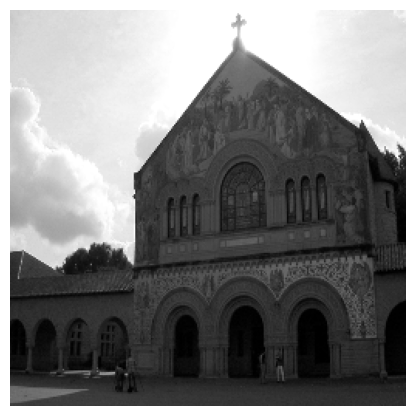

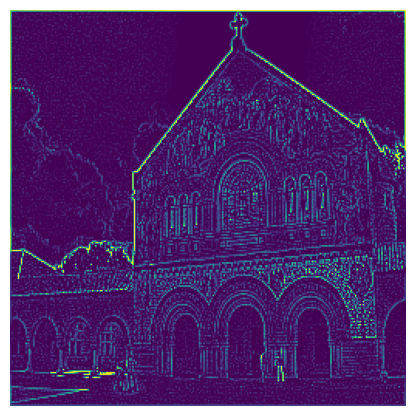

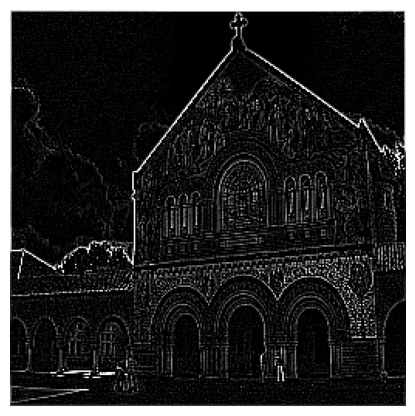

gradient mean squared error:
Groundtruth: 1.328887939453125


KeyError: 'Groundtruth'

In [324]:
from PIL import Image, ImageFilter
import cv2


def draw_figure(image, text, save_path, cmap="gray"):
    font = {
        # 'family': 'serif',
        "color" : "white",
        "weight": "bold",
        "size"  : 28,
    }
    fig, axs       = plt.subplots(1, 1)
    dpi            = 100
    left, width    = 0, 1
    bottom, height = 0, 1
    right          = left   + width
    center_x       = left   + width / 2
    center_y       = bottom + height / 2
    top            = bottom + height
    p              = plt.Rectangle((left, bottom), width, height, linewidth=0, fill=False, facecolor='none', edgecolor=None)
    p.set_transform(axs.transAxes)
    p.set_clip_on(True)

    axs.add_patch(p)
    axs.imshow(image, cmap=cmap)
    axs.title.set_text("")
    axs.text(right - 0.01, bottom + 0.01, text,
             horizontalalignment = "right",
             verticalalignment   = "bottom",
             transform           = axs.transAxes,
             fontdict            = font)
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_axis_off()
    plt.show()
    fig.savefig(save_path, dpi=dpi, bbox_inches="tight", pad_inches=0)


if save_images:
    gt_pil      = Image.fromarray(gt_img)
    gradient_gt = gt_pil.filter(ImageFilter.FIND_EDGES)

    # Debugging Purpose
    '''
    gray       = cv2.imread("data/51_ref_dav2_vitl_c.jpg", cv2.IMREAD_GRAYSCALE)
    ksize       = 3
    gX          = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
    gY          = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)
    gX          = cv2.convertScaleAbs(gX)
    gY          = cv2.convertScaleAbs(gY)
    combined    = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)
    gt_pil      = Image.fromarray(combined)
    gradient_gt = gt_pil.filter(ImageFilter.FIND_EDGES)
    '''

    gt_pil.save(f"{output_dir}/groundtruth.jpg")
    draw_figure(gt_img, "", f"{output_dir}/groundtruth_color.jpg", cmap="viridis")
    draw_figure(gt_img, "", f"{output_dir}/groundtruth_gray.jpg")
    gradient_gt.save(f"{output_dir}/groundtruth_gradient.jpg")
    draw_figure(gradient_gt, "", f"{output_dir}/groundtruth_gradient_color.jpg", cmap="viridis")
    draw_figure(gradient_gt, "", f"{output_dir}/groundtruth_gradient_gray.jpg")

    print("gradient mean squared error:")
    for i, n in enumerate(outputs):
      arr      = outputs[n][-1]
      data8    = (255 * (np.clip(arr, -1, 1) +1 ) / 2).astype(np.uint8)
      img      = Image.fromarray(data8)
      gradient = img.filter(ImageFilter.FIND_EDGES)
      print(f"{n}: {mse(gradient_gt, gradient)}")

      n_              = n.lower()
      img_            = f"{n_}_{total_steps}.jpg"
      img_gray_       = f"{n_}_gray_{total_steps}.jpg"
      img_color_      = f"{n_}_color_{total_steps}.jpg"
      gradient_       = f"{n_}_gradient_{total_steps}.jpg"
      gradient_gray_  = f"{n_}_gradient_gray_{total_steps}.jpg"
      gradient_color_ = f"{n_}_gradient_color_{total_steps}.jpg"

      img.save(f"{output_dir}/{img_}")
      gradient.save(f"{output_dir}/{gradient_}")

      draw_figure(img, f"PSNR: {psnrs[n]:.2f}", f"{output_dir}/{img_gray_}")
      draw_figure(img, f"PSNR: {psnrs[n]:.2f}", f"{output_dir}/{img_color_}", cmap="viridis")
      draw_figure(gradient, f"PSNR: {psnrs[n]:.2f}", f"{output_dir}/{gradient_gray_}")
      draw_figure(gradient, f"PSNR: {psnrs[n]:.2f}", f"{output_dir}/{gradient_color_}", cmap="viridis")